In [ ]:
''' 
@@ Authur: Sanyukta Suman

Which kind of data set did you choose for your Project?

Answer- I have choosen the dataset which contains movie reviews from Rotten Tomatoes.

There are four features in this data set. They are:
1. Date -Date the review is posted.
2. Rating- User rating out of 5 (where 1 being the lowest and 5 being the highest)
3. Helpful- How many users think the review has been helpful.
4. Review- TextReview Description.


------ 
------ Objective of this project is multi-class classification,instead of positive/negative
prediction, we will classify phares in sentiment scale 0 to 4
where 0 is the lowest sentiment (negative) and 4 is the highest sentiment(positive)-------
'''



In [ ]:
# Describe the RV-Fuction
'''The RV-function of the dataset is procedure of giving rating, measure of helpfullness and typing Review Text'''

#Define Data Value Space 
'''Data value set(DVS) ={PhraseId, SentenceId, Phrase, Sentiment}'''

In [1]:
#importing important libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer

import unicodedata, re, string
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.manifold import TSNE

from scipy import stats

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

import warnings
warnings.filterwarnings("ignore")

In [2]:
#reading review data from the csv file "Reviews.csv"

df_train = pd.read_csv("train.tsv", sep = "\t", nrows=100)
df_test = pd.read_csv("test.tsv", sep = "\t", nrows=100)


In [ ]:
#Printing 100 samples from the data set
df_test.head()
df_test.shape

In [ ]:
df_train.head()
df_train.shape

In [ ]:
#Train Data description
df_train.info()

In [ ]:
df_train ['Phrase'][0]

In [ ]:
#extracting location of rows from the training data set whose sentence id is ==1
df_train.loc[df_train['SentenceId'] == 1]

In [ ]:
'''In the train data from the individual movie reviews phrases are taken out
of the context and it is split into smaller parts, each part is assigned with the sentiment category.
The data is fairly clean. Before the pre-processing of data, let's look at the data distribution,to see if the classes 
in training data is fairly distributed.

'''

In [ ]:
senti_count=[]
senti_count=df_train['Sentiment'].value_counts()

In [ ]:
senti_count

In [ ]:
#Data distribution Ananlysis

#Let's see the distribution of data on the basis of sentiments

dist = df_train.groupby(["Sentiment"]).size()

fig, ax = plt.subplots(figsize=(12,8))

sns.barplot(dist.keys(), dist.values);
plt.savefig('senti_count')

In [ ]:
from scipy.stats import norm, kurtosis
kurtosis(df_train)

In [ ]:
df_train.drop('PhraseId', axis=1).plot(kind='box', subplots=True, layout=(2,2), sharex=False, sharey=False, figsize=(9,9), 
                                        title='Box Plot for each input variable')
#plt.savefig('fruits_box')
plt.show()

In [ ]:
'''Sentiment class seems to follow normal distribution, with most frequently distributed class 
being 2.''' 

In [ ]:
'''Data in the form of text needs to be tokenized into numeric format. 
Before converting words into numerics, I will filter out spaces and puntuation and use lemmetization to reduce dimensionality.

Note: At this point, I will not filter out stop words, because in case of movie phrases such as 
"this movie is shit" and "this is movie is the shit" has totally different meaning, therefore I want to keep this
information since it will help me analyze the sentiment of the review better'''

In [3]:
df_train['Phrase'][:10]

0    A series of escapades demonstrating the adage ...
1    A series of escapades demonstrating the adage ...
2                                             A series
3                                                    A
4                                               series
5    of escapades demonstrating the adage that what...
6                                                   of
7    escapades demonstrating the adage that what is...
8                                            escapades
9    demonstrating the adage that what is good for ...
Name: Phrase, dtype: object

In [3]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [4]:
#removing puntuations
df_train.Phrase=df_train.Phrase.apply(lambda x: x.translate(str.maketrans('','',string.punctuation)).lower())

In [5]:
#Tokenization of sentence
df_train.Phrase=df_train.Phrase.str.split(' ')

In [ ]:
df_train['Phrase'][:10]

In [6]:
#Remove stopwords

from nltk.stem import PorterStemmer
porter=PorterStemmer()
df_train.Phrase=df_train.Phrase.apply(lambda x: [porter.stem(w) for w in x])
stopwords_e=stopwords.words('english')

df_train.Phrase=[w for w in df_train.Phrase if w not in stopwords_e]
df_train.Phrase.head()

0    [a, seri, of, escapad, demonstr, the, adag, th...
1    [a, seri, of, escapad, demonstr, the, adag, th...
2                                            [a, seri]
3                                                  [a]
4                                               [seri]
Name: Phrase, dtype: object

In [7]:
#Lemmetize words
lemmar=WordNetLemmatizer()
df_train.Phrase=df_train.Phrase.apply(lambda x: [lemmar.lemmatize(w) for w in x])

#stemming words
snow=SnowballStemmer('english')
df_train.Phrase=df_train.Phrase.apply(lambda x: [snow.stem(w) for w in x])

In [8]:
df_train['Phrase'][:10]

0    [a, seri, of, escapad, demonstr, the, adag, th...
1    [a, seri, of, escapad, demonstr, the, adag, th...
2                                            [a, seri]
3                                                  [a]
4                                               [seri]
5    [of, escapad, demonstr, the, adag, that, what,...
6                                                 [of]
7    [escapad, demonstr, the, adag, that, what, is,...
8                                            [escapad]
9    [demonstr, the, adag, that, what, is, good, fo...
Name: Phrase, dtype: object

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer,TfidfTransformer
vector=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b')

df_train.Phrase=df_train.Phrase.apply(lambda x: ' '.join(x))
vector1=vector.fit(df_train.Phrase)

df_train_feature=vector1.transform(df_train.Phrase)
df_train_feature.toarray()


array([[0.21906019, 0.15361191, 0.1718349 , ..., 0.        , 0.        ,
        0.        ],
       [0.1989937 , 0.2790813 , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.5197641 , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
lr=LogisticRegression(multi_class='ovr')

In [11]:
lr=lr.fit(df_train_feature,df_train.Sentiment)
## Coefficient
lr.coef_

array([[ 0.31736048, -0.09186175, -0.03585558,  0.31689351, -0.00899072,
        -0.23210304,  0.25093287, -0.04353209, -0.20138992,  0.01835783,
         0.03342382,  0.03342382, -0.13260162,  0.02886438, -0.18499961,
        -0.07348288,  0.47415691,  0.47415691,  0.12610809, -0.13022548,
        -0.23210304, -0.14655932, -0.03209619, -0.07635674,  0.18795618,
         0.51076297,  0.04489707,  0.60831519,  0.47415691, -0.15215348,
        -0.07635674, -0.15141279, -0.00370793,  0.47415691,  0.02191753,
         0.04981103,  0.12610809, -0.02869951, -0.10928643,  0.26869834,
         0.47415691,  0.47415691,  0.25358698, -0.05443713,  0.34424907,
         0.00683312, -0.1911994 ,  0.47415691],
       [ 0.06131413,  0.32798898,  0.22910476, -0.08356008, -0.65857862,
        -1.03313046, -0.04502771,  0.2452186 , -1.57040434,  0.14001179,
         0.20578998, -0.65116773,  0.12082367,  0.20846068,  0.16616684,
        -0.82970684, -0.40064996, -0.40064996,  0.14670356, -0.29881587,
   

In [12]:
train_predict=lr.predict(df_train_feature)

In [13]:
## the number of data in each class
df_train.Sentiment.value_counts().sort_index()

1     6
2    80
3    10
4     4
Name: Sentiment, dtype: int64

In [18]:
## number of data in predict result
np.unique(train_predict,return_counts=True)

(array([2, 3], dtype=int64), array([97,  3], dtype=int64))

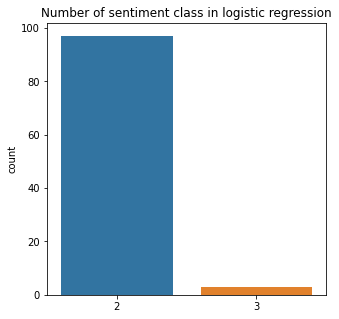

In [21]:
## Plot predict result
plt.figure(figsize=(5,5))
ax=plt.axes()
ax.set_title('Number of sentiment class in logistic regression')
sns.countplot(train_predict)

In [14]:
print(classification_report(train_predict, df_train.Sentiment))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           2       1.00      0.82      0.90        97
           3       0.30      1.00      0.46         3
           4       0.00      0.00      0.00         0

    accuracy                           0.83       100
   macro avg       0.33      0.46      0.34       100
weighted avg       0.98      0.83      0.89       100



In [24]:
from sklearn.tree import DecisionTreeClassifier
ds=DecisionTreeClassifier()
ds.fit(df_train_feature, df_train.Sentiment)


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [25]:
print(ds.feature_importances_)

[0.09292447 0.         0.         0.         0.05299527 0.05760369
 0.         0.         0.22860153 0.         0.         0.05425707
 0.         0.02352518 0.         0.10062159 0.         0.09886312
 0.         0.         0.05759935 0.         0.         0.
 0.         0.06570255 0.         0.         0.         0.
 0.         0.08267854 0.         0.         0.         0.03982477
 0.         0.         0.         0.04480287 0.         0.
 0.         0.         0.         0.         0.         0.        ]


In [26]:
ds_train_pred=ds.predict(df_train_feature)

In [28]:
df_train.Sentiment.value_counts().sort_index()

1     6
2    80
3    10
4     4
Name: Sentiment, dtype: int64

In [29]:
## Number of predict class
np.unique(ds_train_pred,return_counts=True)

(array([1, 2, 3, 4], dtype=int64), array([ 6, 80, 11,  3], dtype=int64))

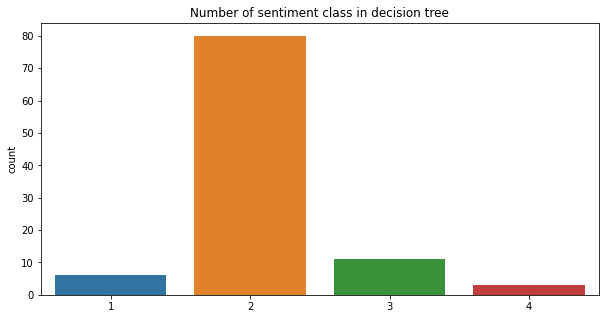

In [33]:
plt.figure(figsize=(10,5))
ax=plt.axes()
ax.set_title('Number of sentiment class in decision tree')
sns.countplot(ds_train_pred)

In [32]:
print(classification_report(ds_train_pred, df_train.Sentiment))


              precision    recall  f1-score   support

           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00        80
           3       1.00      0.91      0.95        11
           4       0.75      1.00      0.86         3

    accuracy                           0.99       100
   macro avg       0.94      0.98      0.95       100
weighted avg       0.99      0.99      0.99       100



In [35]:
from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier()
rf.fit(df_train_feature, df_train.Sentiment)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

[0.02279513 0.00046733 0.00225712 0.00896445 0.07612871 0.07612437
 0.0223314  0.00199093 0.1198458  0.         0.0003047  0.07902359
 0.02266639 0.00038403 0.01370687 0.09786638 0.         0.01018331
 0.00098483 0.02255877 0.05524201 0.02266307 0.00030883 0.00099698
 0.01873889 0.03508091 0.00762131 0.01487438 0.04510634 0.01704658
 0.00201698 0.0649958  0.00225347 0.         0.0002246  0.00571838
 0.00492724 0.00047125 0.02419178 0.01049142 0.0379709  0.
 0.00581829 0.00133728 0.00974649 0.00040144 0.0331713  0.        ]


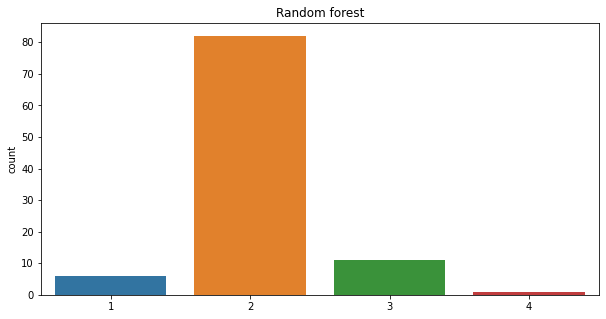

In [38]:
print(rf.feature_importances_)
rf_train_pred=rf.predict(df_train_feature)
plt.figure(figsize=(10,5))
ax=plt.axes()
ax.set_title('Random forest')
sns.countplot(rf_train_pred)

In [39]:
print(classification_report(rf_train_pred, df_train.Sentiment))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00         6
           2       1.00      0.98      0.99        82
           3       0.90      0.82      0.86        11
           4       0.25      1.00      0.40         1

    accuracy                           0.96       100
   macro avg       0.79      0.95      0.81       100
weighted avg       0.98      0.96      0.97       100



In [44]:
## Import every packages
from scipy import stats
import string
from nltk.corpus import stopwords
stopwords_e=stopwords.words('english')
from nltk.stem import SnowballStemmer
snow=SnowballStemmer('english')
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import  RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer,TfidfTransformer
vector=TfidfVectorizer(stop_words='english')

In [45]:
## Preprocess function
def data_preprocess(text):
    text_nonpunc=[w.lower() for w in text if w not in string.punctuation]
    text_nonpunc=''.join(text_nonpunc)
    text_rmstop=[x for x in text_nonpunc.split(' ') if x not in stopwords_e]
    text_stem=[snow.stem(w) for w in text_rmstop]
    text1=' '.join(text_stem)
    return (text1)

In [46]:
## Notice: Class name and the first def should have a blank line
class EstimatorSelection:
    
    def __init__(self, models):
        self.models=models
        self.keys=models.keys()
        self.results={}
        self.modelfit={}
        self.modelpredict={}
    def fit(self, x, y):
        x1=x.apply(lambda i: data_preprocess(i))
        x_feature1=vector.fit_transform(x1)
        for key in self.keys:
            model=self.models[key]
            self.modelfit[key]=model.fit(x_feature1,y)
            y_pred=model.predict(x_feature1)
            self.results[key]=classification_report(y, y_pred,output_dict=True)
    def predict(self,test_x):
        test_x1=test_x.apply(lambda i: data_preprocess(i))
        test_feature1=vector.transform(test_x1)
        test_frames=[]
        for key in self.keys:
            modelfit=self.modelfit[key]
            test_y=modelfit.predict(test_feature1)
            test_frame=pd.DataFrame(test_y,columns=[key])
            test_frames.append(test_frame)
        predict_frame=pd.concat(test_frames,axis=1)            
        return(predict_frame)     
    def summary(self):
        Frames=[]
        for key in self.keys:
            result=self.results[key]
            Frame=pd.DataFrame(result['macro avg'], index=[key])
            Frames.append(Frame)
        result_sum=pd.concat(Frames)
        return result_sum.iloc[:,:3]

In [47]:
## Models want to predict on test data
models = { 
    'LogisticClassifier': LogisticRegression(multi_class='ovr'),
    'RandomforestClassifier':RandomForestClassifier(),
    'DecisionTreeClassifier':DecisionTreeClassifier()
}


In [48]:
model_compare=EstimatorSelection(models)

In [49]:
model_compare.fit(df_train.Phrase, df_train.Sentiment)

In [51]:
summary=model_compare.summary()
summary

,precision,recall,f1-score
LogisticClassifier,0.454082,0.300000,0.308052
RandomforestClassifier,0.857123,0.756250,0.785384
DecisionTreeClassifier,0.903869,0.776042,0.831402


In [53]:
predict_result=model_compare.predict(df_test.Phrase)
predict_result

,LogisticClassifier,RandomforestClassifier,DecisionTreeClassifier
0,2,2,2
1,2,2,2
2,2,2,2
3,2,2,2
4,2,2,2
...,...,...,...
95,2,2,2
96,2,2,2
97,2,2,2
98,2,2,2


In [55]:
predict_result1=predict_result.reset_index().rename(columns={'index':'case'})
predict_result2=pd.melt(predict_result1,id_vars='case', value_vars=['LogisticClassifier', 'RandomforestClassifier', 'DecisionTreeClassifier'])

In [56]:
predict_result2=pd.melt(predict_result1,id_vars='case', value_vars=['LogisticClassifier', 'RandomforestClassifier', 'DecisionTreeClassifier'])
predict_result2

,case,variable,value
0,0,LogisticClassifier,2
1,1,LogisticClassifier,2
2,2,LogisticClassifier,2
3,3,LogisticClassifier,2
4,4,LogisticClassifier,2
...,...,...,...
295,95,DecisionTreeClassifier,2
296,96,DecisionTreeClassifier,2
297,97,DecisionTreeClassifier,2
298,98,DecisionTreeClassifier,2


In [57]:
predict_result3=predict_result2.groupby(['variable','value']).size().reset_index().rename(columns={0:'count'})
predict_result3

,variable,value,count
0,DecisionTreeClassifier,2,100
1,LogisticClassifier,2,100
2,RandomforestClassifier,2,100


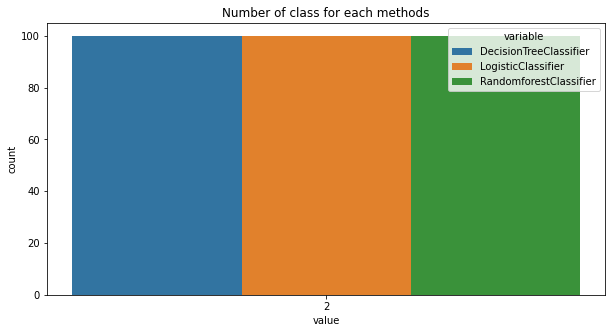

In [58]:
plt.figure(figsize=(10,5))
ax=plt.axes()
ax.set_title('Number of class for each methods')
sns.barplot(x='value', y='count', hue='variable', data=predict_result3)

In [54]:
predict_result1=predict_result.reset_index().rename(columns={'index':'case'})
predict_result2=pd.melt(predict_result1,id_vars='case', value_vars=['LogisticClassifier', 'RandomforestClassifier', 'DecisionTreeClassifier'])